In [106]:
import numpy as np

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, BatchNormalization
from tensorflow.keras import optimizers, losses
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt

In [223]:
class Discriminator(Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(32, activation='relu')
        self.dense_3 = Dense(32, activation='relu')
        self.flat_layer = Flatten()
        self.output_layer = Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.flat_layer(x)
        output = self.output_layer(x)
        return output
    
    
class Generator(Model):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.dense_1 = Dense(7*7*256, activation='relu', input_shape=(100,), name='dense_1')
        self.reshape = Reshape((7, 7, 256), name='reshape')
        
        self.conv2dt_1 = Conv2DTranspose(128, (3, 3), strides=1, padding='same', name='conv2dt_1')
        self.bn1 = BatchNormalization(name='bn1')
        
        self.conv2dt_2 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', name='conv2dt_2')
        self.bn2 = BatchNormalization(name='bn2')
        
        self.conv2dt_3 = Conv2DTranspose(1, (3, 3), strides=2, padding='same', 
                                         activation='tanh', name='conv2dt_3')
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.reshape(x)
        x = self.conv2dt_1(x)
        x = self.bn1(x)
        x = self.conv2dt_2(x)
        x = self.bn2(x)
        output = self.conv2dt_3(x)
        return output
    
    
class GAN(Model):
    def __init__(self, latent_dim, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.discriminator = Discriminator()
        self.generator = Generator()
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        fake_img = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_img = self.generator(fake_img)
        both_img = tf.concat([fake_img, data], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)),
                            tf.zeros((batch_size, 1))],
                            axis=0)
        labels += 0.05 * tf.random.uniform(shape=(2 * batch_size, 1))
        with tf.GradientTape() as tape:
            preds = self.discriminator(both_img)
            d_loss = self.loss_fn(labels, preds)
            
        grad = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grad, self.discriminator.trainable_weights))
        
        random_input = tf.random.normal(shape=(batch_size, self.latent_dim))
        gen_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            preds = self.discriminator(self.generator(random_input))
            g_loss = self.loss_fn(gen_labels, preds)
            
        grad = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grad, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}  

In [224]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, -1)
x_train = (x_train - 127.5) / 127.5
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [225]:
def loss_fn(labels, preds):
    return losses.BinaryCrossentropy(from_logits=True)(labels, preds)

d_optimizer = optimizers.Adam(lr=0.0001)
g_optimizer = optimizers.Adam(lr=0.0001)

model = GAN(latent_dim=100)

model.compile(d_optimizer, g_optimizer, loss_fn)
model.fit(x_train, epochs=1)

1875/1875 [==============================] - 216s 115ms/step - d_loss: 0.6703 - g_loss: 0.7763


In [230]:
example = tf.random.normal((1, 100))

In [231]:
generator = model.generator

In [232]:
result = generator(example)

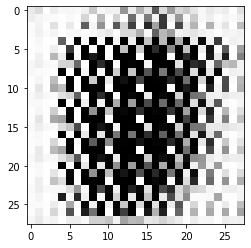

In [233]:
plt.imshow(result[0], cmap='gray_r')